# Demonstrating the effects of denoising algoritms on text images
## By Oliver Chalkley

I have created a Python library to help with this analysis.

For this document (unless otherwise stated) we will refer to *original*, *noisy*, and *denoised* images. 

The *original* images are images that do not and have never contained noise. Each *original* image has two corresponding *noisy* images (*gaussian noise* and *quasi-crystal noise*) which is the original image plus either Gaussian white noise or quasi-crystal noise. Each *noisy* image has a corresponding *denoised* image for every denoising algorithm attempted.

In [1]:
import algo_test as at # import my library

In [2]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import random as rand
import pickle as pkl

from geneticalgorithm import geneticalgorithm as ga
import multiprocessing as mp
plt.style.use('seaborn')

First we get all the paths and file names for the images without noise (the original image) and the image with noise (noisy image).

In [3]:
### GET ALL FILENAMES
picture_path = at.get_picture_path() # returns the path to all the images on my VM
denoised_path = '/home/advai-admin-root/projects/ocr_lib/denoised/' # is the path that I wish to save denoised images

all_files = at.get_all_filenames(picture_path) # get all png files in picture_path
all_filenames = [filename.split("/")[-1] for filename in all_files] # remove path from filename

### FILTER FILENAMES
original_filenames_dict = {'b': 0, 'bt': 1, 's': -1, 'dt': 0, 'do': -1, 'string_idx': -1, 'f': -1} # create a dictionary that reprsents all the images with no noise
original_filenames = at.filter_filenames(all_filenames, original_filenames_dict)

gaussian_filenames = []
crystal_filenames = []
for original_fn in original_filenames:
    # get the image properties of this filename
    original_data = at.extract_data_from_filename(original_fn)
    
    # change the image properties from original to gaussian white noise and create corresponding filename
    tmp_gaussian_data = original_data.copy()
    tmp_gaussian_data['bt'] = 0
    gaussian_filenames += [at.create_filename(**tmp_gaussian_data)]
    
    # chnage the image proterties to quasi-crystal noise and create corresponding filename
    tmp_crystal_data = original_data.copy()
    tmp_crystal_data['bt'] = 2
    crystal_filenames += [at.create_filename(**tmp_crystal_data)]

The following gives you an example of an original image with it's corresponding noisy images.

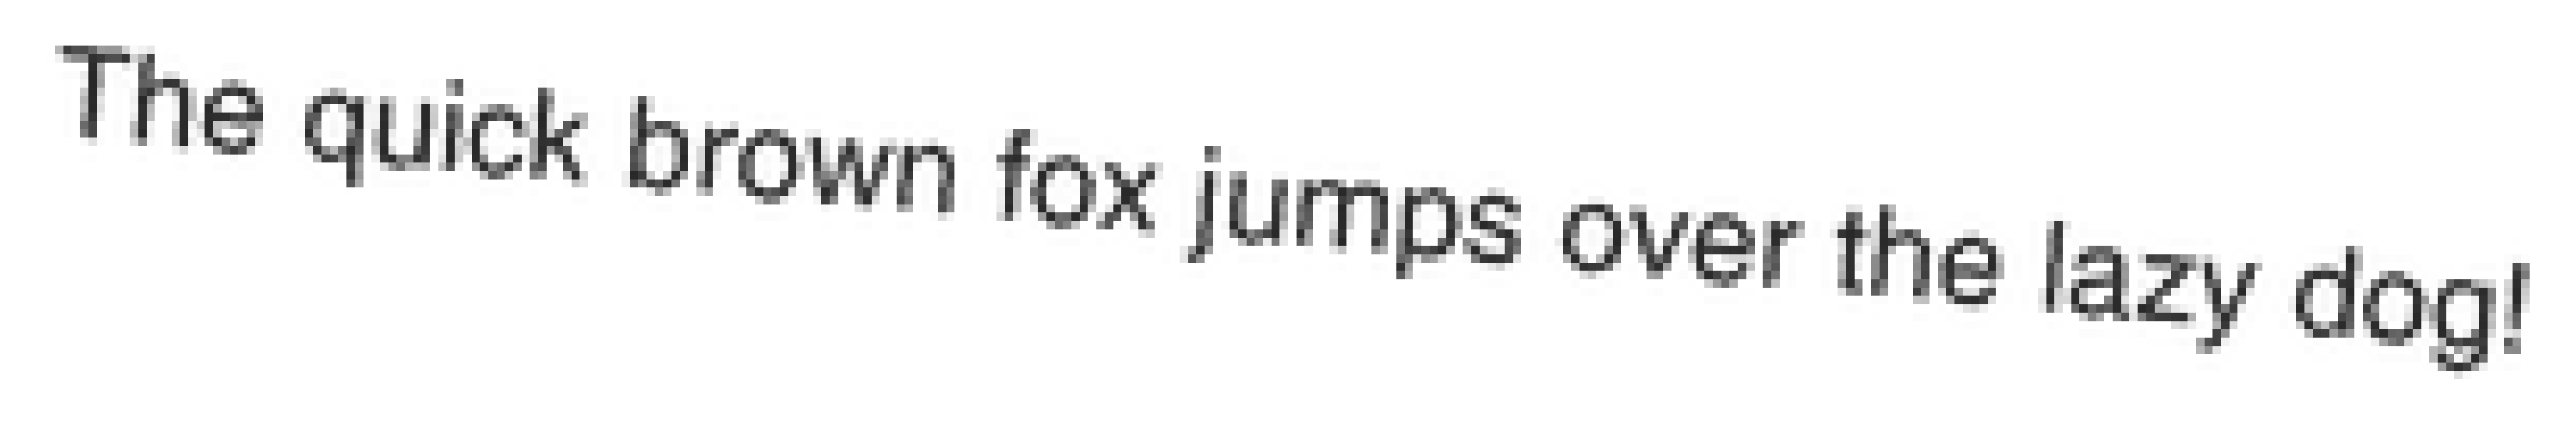

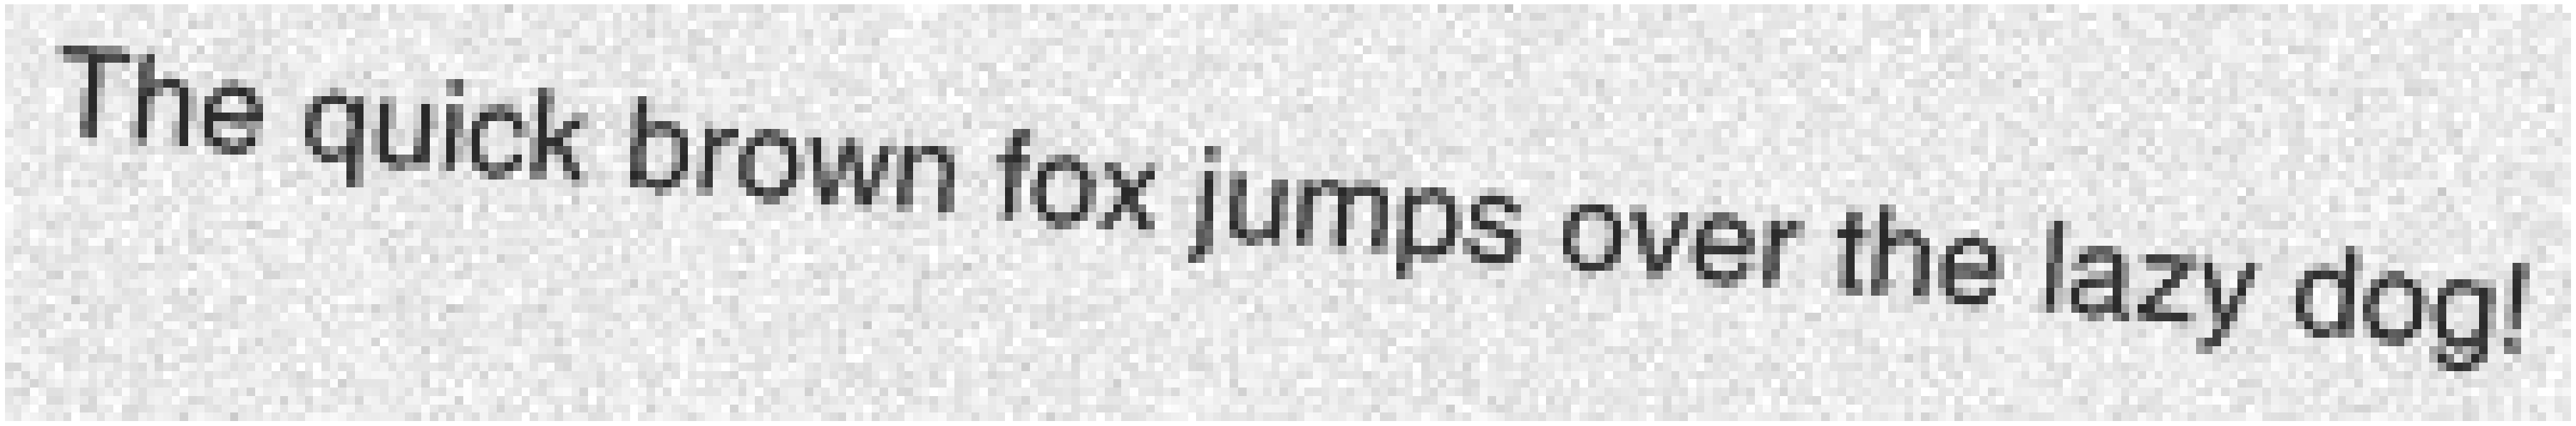

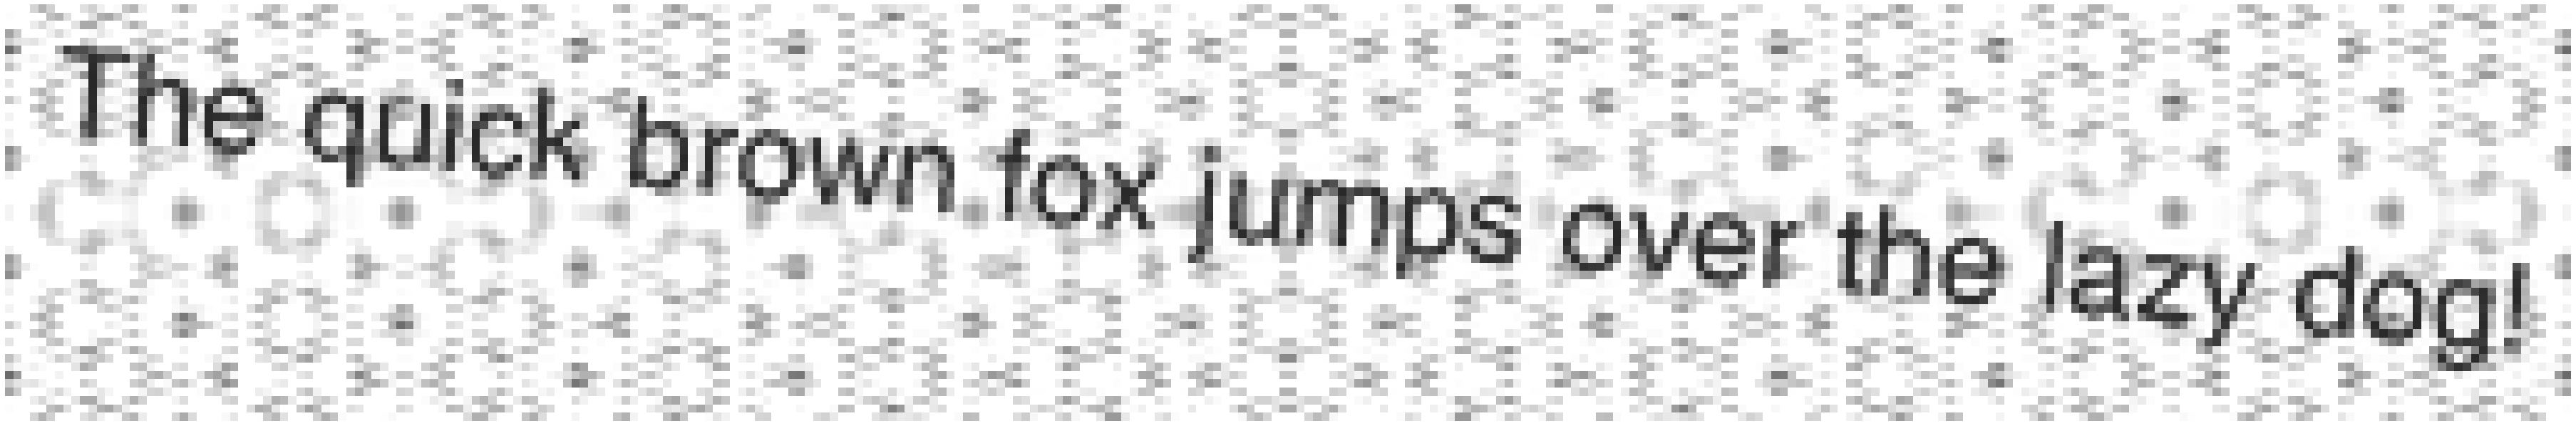

In [4]:
demo_idx = 0
demo_fullpath_o = picture_path + original_filenames[demo_idx]
demo_fullpath_g = picture_path + gaussian_filenames[demo_idx]
demo_fullpath_c = picture_path + crystal_filenames[demo_idx]
at.display_file(demo_fullpath_o)
at.display_file(demo_fullpath_g)
at.display_file(demo_fullpath_c);

In the next section we will manually inspect the affects of the denoising algorithms.

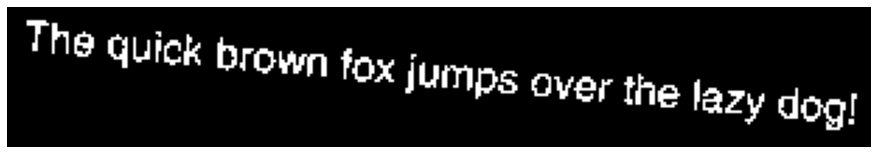

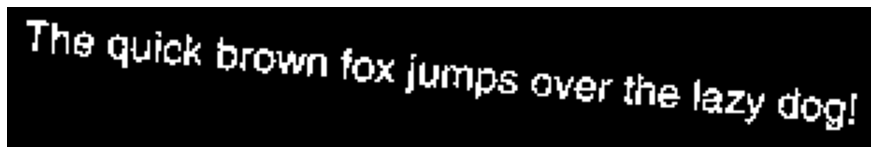

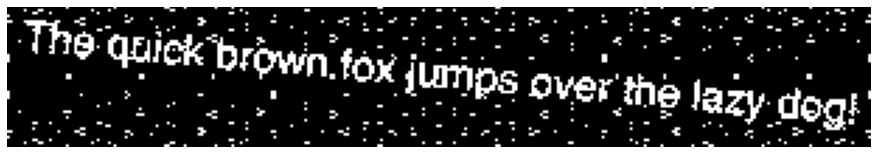

In [5]:
# load, greyscale and binarise the images and re-view them
img_o = at.callum_binarise(demo_fullpath_o)
img_g = at.callum_binarise(demo_fullpath_g)
img_c = at.callum_binarise(demo_fullpath_c)
at.display_image(img_o)
at.display_image(img_g)
at.display_image(img_c);

# now we invert img_c
#img_c = cv2.bitwise_not(img_c)
#at.display_image(img_c);

We can see here that the callcums binarisation method has actually completely denoised the Gaussian white noise and whilst the quasi-crystal noise is still present it looks far more managable now since it is in clumps rather than complex patterns. It is also worth noting that the text has been affected quite significantly in a negative way.

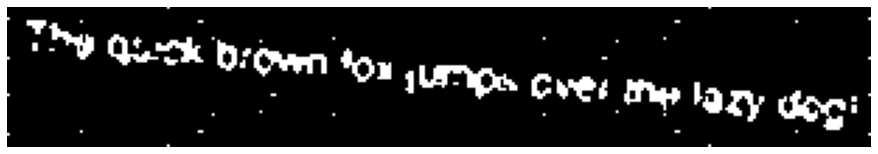

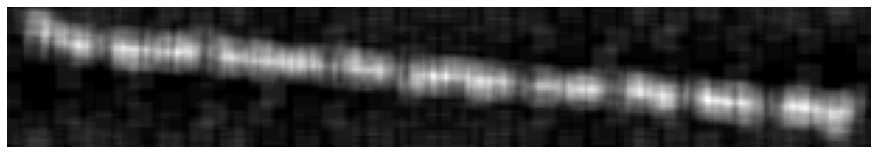

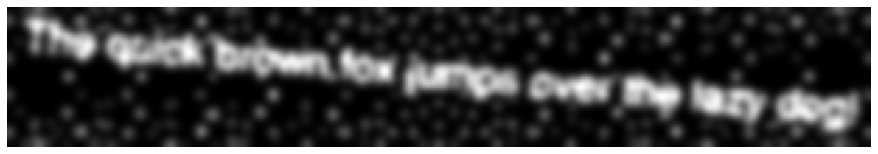

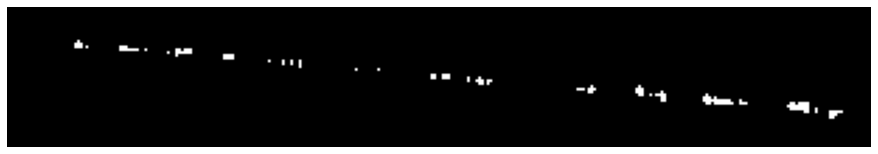

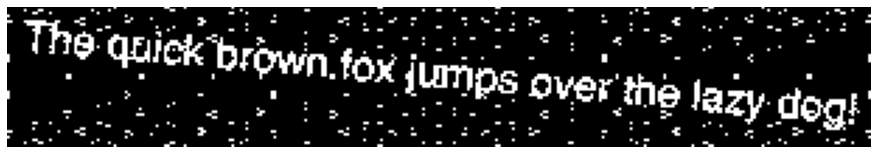

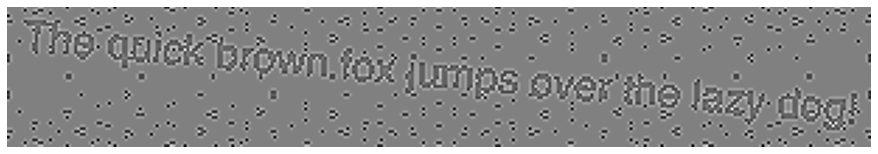

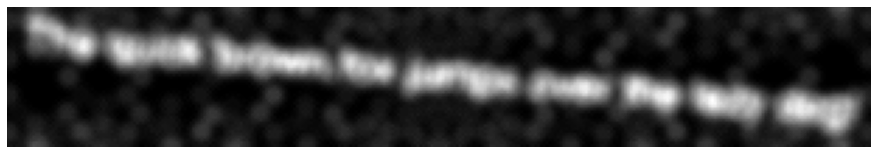

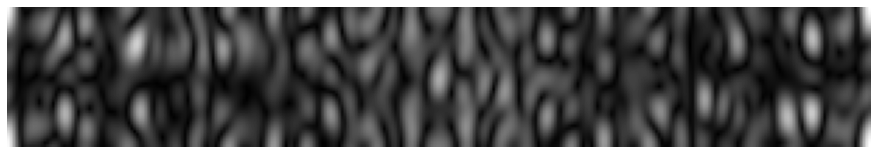

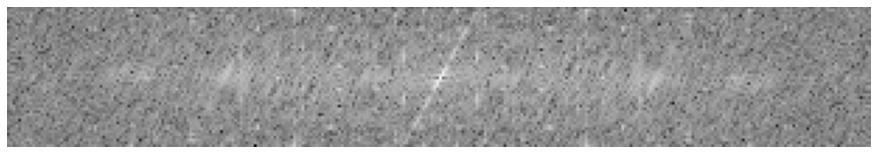

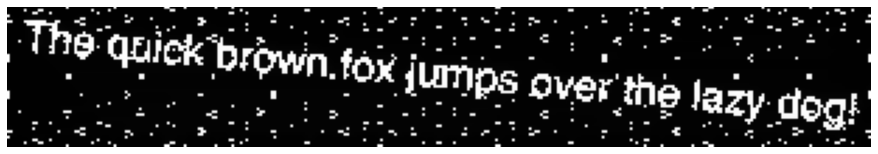

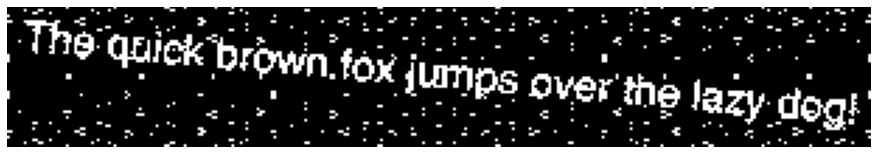

In [6]:
# get all the denoising functions
kernal_size = 9
sigma_x, sigma_y = 0, 0
radius, percent = 2, 150

nr = at.callum_noise_removal(img_c)
meanf = at.mean_filter(img_c, kernal_size, kernal_size)
gaussf = at.gaussian_filter(img_c, kernal_size, sigma_x, sigma_y)
medianf = at.median_filter(img_c, kernal_size)
conservativef = at.conservative_filter(img_c, kernal_size)
laplacianf = at.laplacian_filter(img_c)
logf = at.laplacian_of_gaussian_filtering(img_c, kernal_size, sigma_x, sigma_y)
lp_dft_f = at.low_pass_dft(img_c)
freq_spectrum = lp_dft_f[1]
lp_dft_f = lp_dft_f[0]
crimminsf = at.crimmins_speckle_removal(img_c)
unsharpf = np.array(at.unsharp_filter(img_c, radius=radius, percent=percent))

at.display_image(nr)
at.display_image(meanf)
at.display_image(gaussf)
at.display_image(medianf)
at.display_image(conservativef)
at.display_image(laplacianf)
at.display_image(logf)
at.display_image(lp_dft_f)
at.display_image(freq_spectrum)
at.display_image(crimminsf)
at.display_image(unsharpf);

We can see that all denoising algorithms performed very badly. An investogation needs to be done into how we can improve this. However, first we will look at the metrics I created to measure the success of algorithms and then once this is established then we can look at optimising algorithm performance with the use of quantitative metrics.

In [7]:
results = at.get_error_breakdown(img_o, img_c, at.callum_noise_removal, {})
results

{'input': {'img_o': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'img_a': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'img_u': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)},
 'total': {'total_undoing_error': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),

It is likely that the text will be deskewed before being denoised but we want to know what the effect of skewing has on the algorithms and so will seperate skewed from not skewed.

In [8]:
# we want the images without noise and with quasi-crystal noise 
no_skew_dict = {'b': -1, 'bt': -1, 's': 360, 'dt': -1, 'do': -1, 'string_idx': -1, 'f': -1}

straight_original_filenames = at.filter_filenames(original_filenames, no_skew_dict)
skewed_original_filenames = [filename for filename in original_filenames if filename not in straight_original_filenames]

straight_crystal_filenames = at.filter_filenames(crystal_filenames, no_skew_dict)
skewed_crystal_filenames = [filename for filename in crystal_filenames if filename not in straight_crystal_filenames]

print(len(original_filenames))
print(len(straight_original_filenames) + len(skewed_original_filenames))

print(len(crystal_filenames))
print(len(straight_crystal_filenames) + len(skewed_crystal_filenames))
print(len(straight_crystal_filenames))

162
162
162
162
27


## Mean filter

Here we do an initial investigation of the mean filter algorithm.

In [9]:
# first test all straight images on the mean filter
straight_original_images = [at.callum_binarise(picture_path + filename) for filename in straight_original_filenames]
straight_crystal_images = [at.callum_binarise(picture_path + filename) for filename in straight_crystal_filenames]
straight_crys_mean_filter = [at.get_error_breakdown(straight_original_images[idx], straight_crystal_images[idx], at.mean_filter, {'kernel_size1': 3, 'kernel_size2': 3}) for idx in range(len(straight_crystal_filenames))]


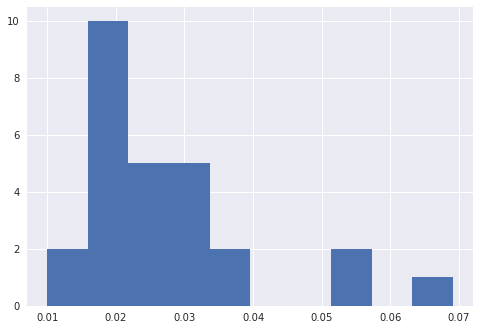

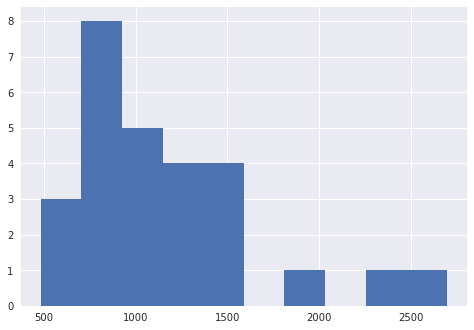

In [10]:
total_errors = pd.DataFrame({'percent': [result['total']['pct_undoing_error'] for result in straight_crys_mean_filter], 'absolute': [result['total']['absolute_undoing_error'] for result in straight_crys_mean_filter]})
total_errors.percent.hist()
plt.show()
total_errors.absolute.hist()
plt.show()

We can see from the hostograms above that the errors are relatively small.

New result:


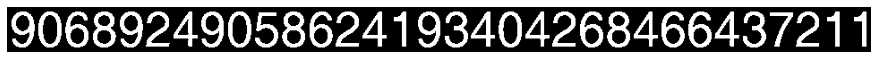

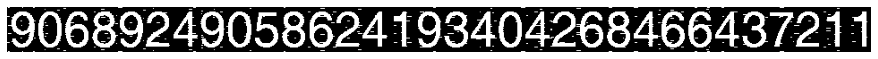

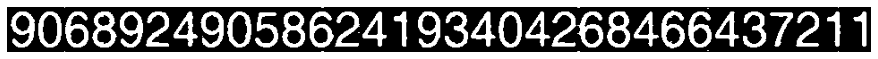

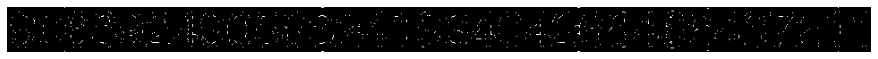

Absolute denoising error:  795.0
Percentage (of total image) denoising error:  0.016476683937823835
New result:


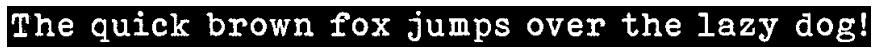

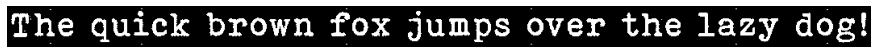

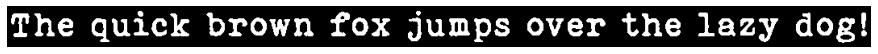

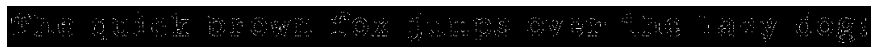

Absolute denoising error:  998.0
Percentage (of total image) denoising error:  0.018636788048552753
New result:


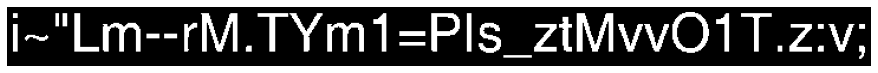

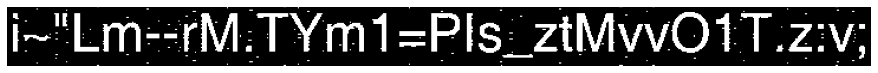

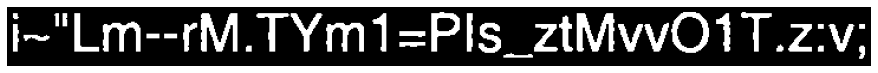

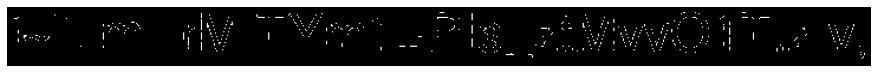

Absolute denoising error:  654.0
Percentage (of total image) denoising error:  0.01789329685362517
New result:


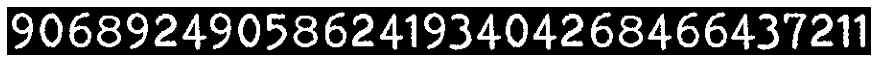

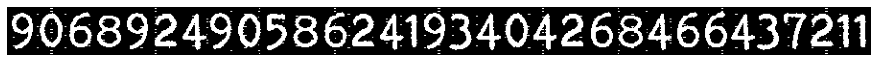

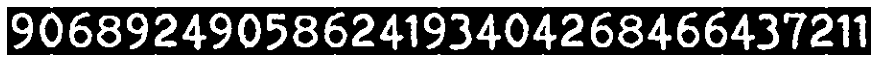

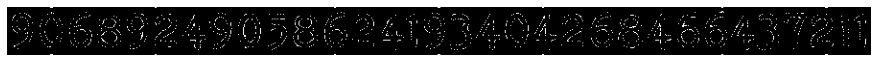

Absolute denoising error:  1519.0
Percentage (of total image) denoising error:  0.033718091009988904
New result:


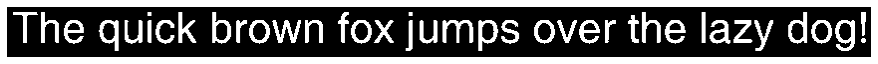

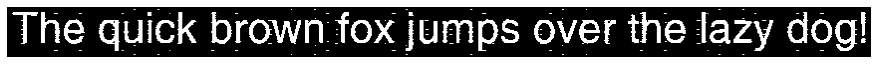

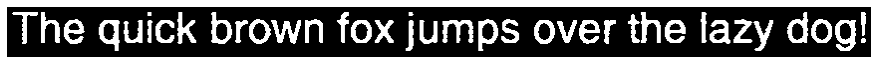

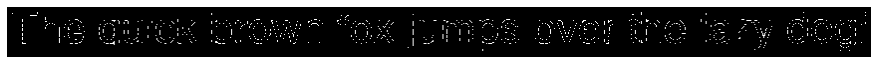

Absolute denoising error:  1199.0
Percentage (of total image) denoising error:  0.02765859284890427
New result:


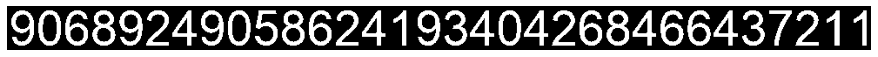

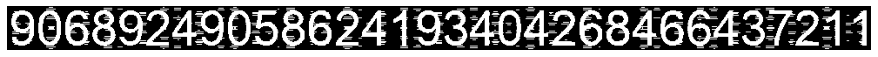

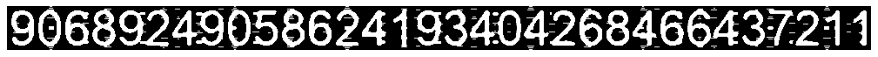

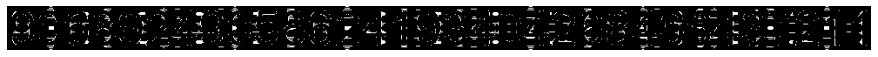

Absolute denoising error:  2696.0
Percentage (of total image) denoising error:  0.054300100704934545
New result:


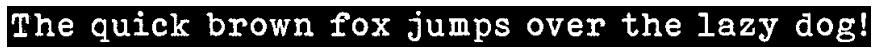

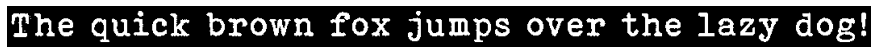

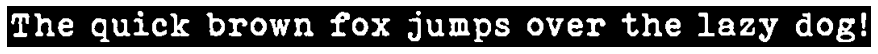

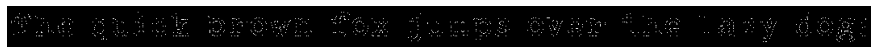

Absolute denoising error:  938.0
Percentage (of total image) denoising error:  0.017516339869281045
New result:


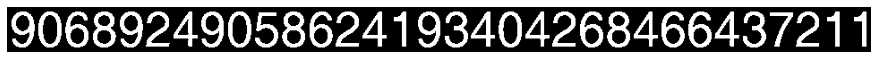

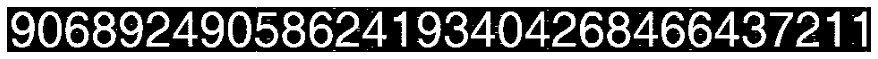

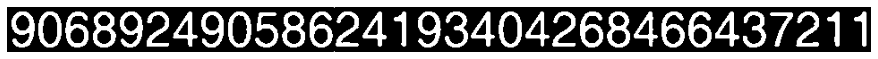

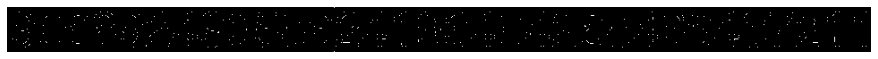

Absolute denoising error:  483.0
Percentage (of total image) denoising error:  0.010010362694300518
New result:


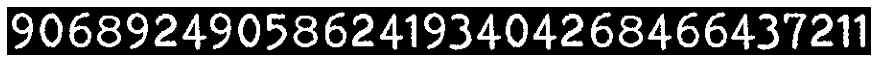

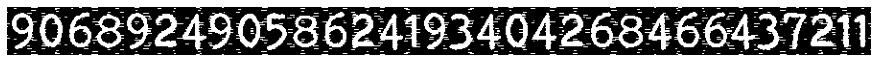

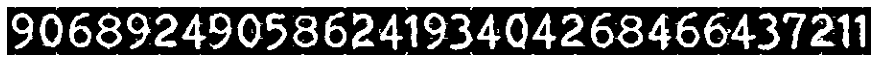

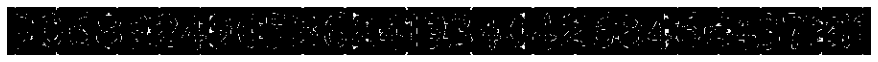

Absolute denoising error:  1319.0
Percentage (of total image) denoising error:  0.02927857935627081
New result:


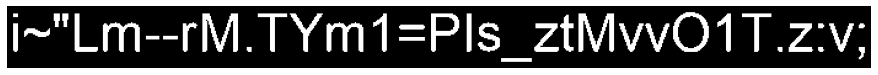

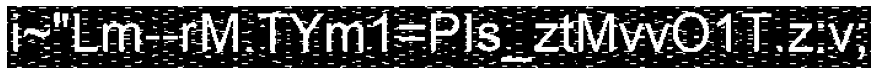

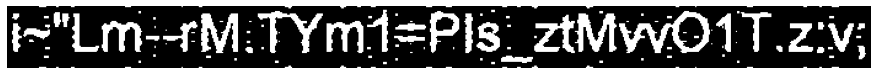

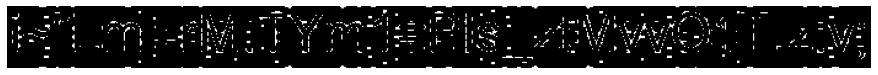

Absolute denoising error:  1851.0
Percentage (of total image) denoising error:  0.052660028449502135


In [11]:
# lets look at some of the total denoised errors
rand_results = rand.sample(straight_crys_mean_filter, 10)
for result in rand_results:
    print('New result:')
    at.display_image(result['input']['img_o'])
    at.display_image(result['input']['img_a'])
    at.display_image(result['input']['img_u'])
    at.display_image(result['total']['total_undoing_error'])
    print('Absolute denoising error: ', result['total']['absolute_undoing_error'])
    print('Percentage (of total image) denoising error: ', result['total']['pct_undoing_error'])

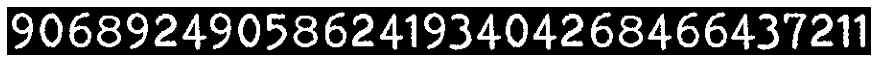

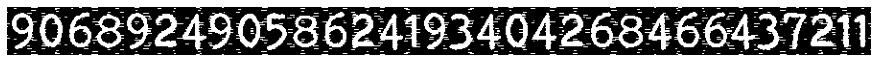

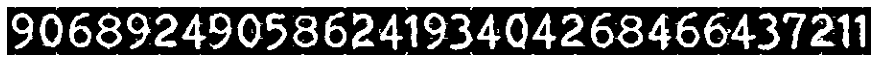

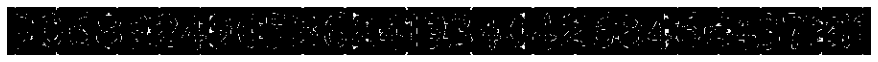

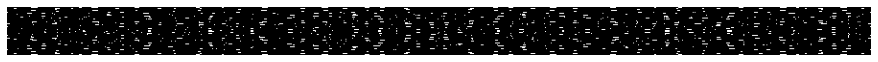

In [12]:
result_no =  -2
at.display_image(rand_results[result_no]['input']['img_o'])
at.display_image(rand_results[result_no]['input']['img_a'])
at.display_image(rand_results[result_no]['input']['img_u'])
#at.display_image(at.callum_binarise_image(rand_results[result_no]['input']['img_u']))
at.display_image(rand_results[result_no]['total']['total_undoing_error'])
at.display_image(at.get_difference(rand_results[result_no]['input']['img_o'], rand_results[result_no]['input']['img_a']))

We can see that although the denoising algorithm works well, it does "smear" the text a bit so that the text gets a little wider. This means that our algorithm classes it as wrong pixels when it actually doesn't really matter. Conversely text moving could cause problems down the road and so not only keeping the letter shape but also the same size and place is not a bad thing.

In [13]:
xsize, ysize = img_o.shape
max_no = max(xsize, ysize)
max_prop = 0.2
max_kernel_size = max_prop * max_no

kernels = range(int(max_kernel_size))


## Optimisation

Let's start by making an objective function  to minimise.

 The best solution found:                                                                           
 [0. 0. 0.]

 Objective function:
 0.0


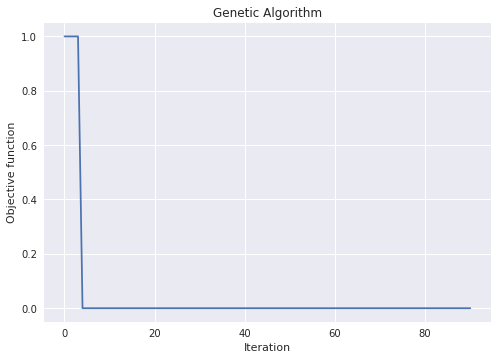

 The best solution found:                                                                           
 [0.50195548 1.         0.        ]

 Objective function:
 1.5019554787123304


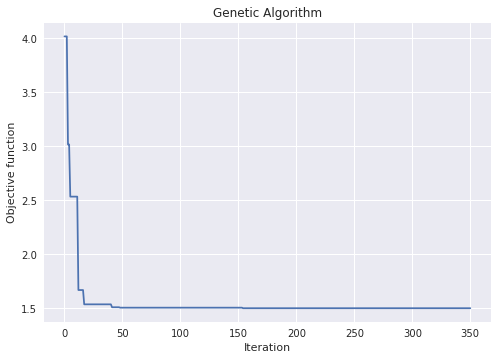

In [14]:
# ga test
def f(X):
    return np.sum(X)

# single type
varbound=np.array([[0,10]]*3)

model=ga(function=f,dimension=3,variable_type='int',variable_boundaries=varbound)

model.run()

# mixed types
varbound=np.array([[0.5,1.5],[1,100],[0,1]])
vartype=np.array([['real'],['int'],['int']])
model=ga(function=f,dimension=3,variable_type_mixed=vartype,variable_boundaries=varbound)

model.run()

In [15]:
varbound=np.array([[0,10]]*3)
varbound

array([[ 0, 10],
       [ 0, 10],
       [ 0, 10]])

In [16]:
def objf_mean_filter(kernel_sizes):
    kernel_size1, kernel_size2 = int(kernel_sizes[0]), int(kernel_sizes[1])
    #kernel_size = int(kernel_size[0])
    #print(kernel_size1)
    #print(type(kernel_size1))
    #print(kernel_size2)
    #print(type(kernel_size2))
    random_indexs = rand.sample(range(len(straight_crystal_filenames)), 10)
    straight_crys_mean_filter = [at.get_error_breakdown(straight_original_images[idx], straight_crystal_images[idx], at.mean_filter, {'kernel_size1': kernel_size1, 'kernel_size2': kernel_size2}) for idx in random_indexs]
    pct_total_error = [result['total']['pct_undoing_error'] for result in straight_crys_mean_filter]
    
    return sum(pct_total_error) / float(len(pct_total_error))

def objf_mean_filter_par(kernel_sizes):
    kernel_size1, kernel_size2 = int(kernel_sizes[0]), int(kernel_sizes[1])
    random_indexs = rand.sample(range(len(straight_crystal_filenames)), 10)
    input_variables = [(straight_original_images[idx], straight_crystal_images[idx], at.mean_filter, {'kernel_size1': kernel_size1, 'kernel_size2': kernel_size2}) for idx in random_indexs]
    with mp.Pool(processes=mp.cpu_count()) as pool:
        straight_crys_mean_filter = pool.starmap(at.get_error_breakdown, input_variables)

    pct_total_error = [result['total']['pct_undoing_error'] for result in straight_crys_mean_filter]
    
    return sum(pct_total_error) / float(len(pct_total_error))

 The best solution found:                                                                           
 [3. 1.]

 Objective function:
 0.011382381618679773


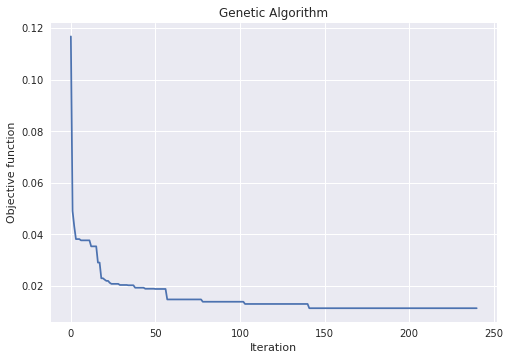

In [17]:
varbound=np.array([[int(1),int(max_kernel_size)]]*2)

algorithm_param = {'max_num_iteration': None,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=objf_mean_filter,dimension=2,variable_type='int',variable_boundaries=varbound, algorithm_parameters=algorithm_param)


model.run()



In [18]:
with open( "mean_filter_ga.pkl", "wb" ) as f:
    pkl.dump(model, f)

In [19]:
def objf_gaussian_filter(input_vars):
    kernel_size, sigma_x, sigma_y = int(2*input_vars[0] + 1), input_vars[1], input_vars[2] 

    random_indexs = rand.sample(range(len(straight_crystal_filenames)), 10)
    straight_crys_mean_filter = [at.get_error_breakdown(straight_original_images[idx], straight_crystal_images[idx], at.gaussian_filter, {'kernel_size': kernel_size, 'sigma_x': sigma_x, 'sigma_y': sigma_y}) for idx in random_indexs]
    pct_total_error = [result['total']['pct_undoing_error'] for result in straight_crys_mean_filter]
    
    return sum(pct_total_error) / float(len(pct_total_error))

In [20]:
help(cv2.GaussianBlur)

Help on built-in function GaussianBlur:

GaussianBlur(...)
    GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]]) -> dst
    .   @brief Blurs an image using a Gaussian filter.
    .   
    .   The function convolves the source image with the specified Gaussian kernel. In-place filtering is
    .   supported.
    .   
    .   @param src input image; the image can have any number of channels, which are processed
    .   independently, but the depth should be CV_8U, CV_16U, CV_16S, CV_32F or CV_64F.
    .   @param dst output image of the same size and type as src.
    .   @param ksize Gaussian kernel size. ksize.width and ksize.height can differ but they both must be
    .   positive and odd. Or, they can be zero's and then they are computed from sigma.
    .   @param sigmaX Gaussian kernel standard deviation in X direction.
    .   @param sigmaY Gaussian kernel standard deviation in Y direction; if sigmaY is zero, it is set to be
    .   equal to sigmaX, if both sigmas are z

In [ ]:
algorithm_param = {'max_num_iteration': None,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

varbound=np.array([[int(1),int(max_kernel_size)],[0, 4*max_kernel_size],[0, 4*max_kernel_size]])
vartype=np.array([['int'],['real'],['real']])
model=ga(function=objf_gaussian_filter,dimension=3,variable_type_mixed=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

model.run()

||||||||||||||||||||______________________________ 40.5% GA is running...

In [ ]:
with open( "gaussian_filter_ga.pkl", "wb" ) as f:
    pkl.dump(model, f)

In [ ]:
with open( "model_test.pkl", "rb" ) as f:
    test_load = pkl.load(f)

In [ ]:
def objf_callum_noise_removal(input_vars):
    dilate_kernel, dilate_iterations = np.ones((int(input_vars[0]), int(input_vars[0])), np.uint8), int(input_vars[1])
    erode_kernel, erode_iterations = np.ones((int(input_vars[2]), int(input_vars[2])), np.uint8), int(input_vars[3])
    morphology_type, morphology_kernel = cv2.MORPH_CLOSE, np.ones((int(input_vars[5]), int(input_vars[5])), np.uint8)
    aperture_linear_size = int(2*input_vars[6] + 1)
    
    random_indexs = rand.sample(range(len(straight_crystal_filenames)), 10)
    straight_crys_mean_filter = [at.get_error_breakdown(straight_original_images[idx], straight_crystal_images[idx], at.callum_noise_removal, {'dilate_kernel': dilate_kernel, 'dilate_iterations': dilate_iterations, 'erode_kernel': erode_kernel, 'erode_iterations': erode_iterations, 'morphology_type': morphology_type, 'morphology_kernel': morphology_kernel, 'aperture_linear_size': aperture_linear_size}) for idx in random_indexs]
    pct_total_error = [result['total']['pct_undoing_error'] for result in straight_crys_mean_filter]
    
    return sum(pct_total_error) / float(len(pct_total_error))

In [ ]:
algorithm_param = {'max_num_iteration': None,\
                   'population_size':300,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

varbound=np.array([[int(1),int(max_kernel_size)],[0, 4],[int(0),int(max_kernel_size)], [0, 4], [0, 1], [int(0),int(max_kernel_size)], [int(0),int(max_kernel_size)]])
vartype=np.array([['int'],['int'],['int'],['int'],['int'],['int'],['int']])
model=ga(function=objf_callum_noise_removal,dimension=7,variable_type_mixed=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

model.run()

In [ ]:
with open( "callum_noise_removal_ga.pkl", "wb" ) as f:
    pkl.dump(model, f)